In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
data = pd.read_csv("/kaggle/input/txn-data/QVI_data.csv")
data.head(5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


Dropping columns which are not needed

In [4]:
data.drop(labels=['PROD_NAME','PACK_SIZE','BRAND','LIFESTAGE','PREMIUM_CUSTOMER'],axis=1,inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LYLTY_CARD_NBR  264834 non-null  int64  
 1   DATE            264834 non-null  object 
 2   STORE_NBR       264834 non-null  int64  
 3   TXN_ID          264834 non-null  int64  
 4   PROD_NBR        264834 non-null  int64  
 5   PROD_QTY        264834 non-null  int64  
 6   TOT_SALES       264834 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 14.1+ MB


We are assigning the right datatypesHere , adjusting the memory usage

In [6]:
data["STORE_NBR"] = data["STORE_NBR"].astype("int16")
data["LYLTY_CARD_NBR"] = data["LYLTY_CARD_NBR"].astype("int32")
data["TXN_ID"] = data["TXN_ID"].astype("int32")
data["PROD_NBR"] = data["PROD_NBR"].astype("int16")
data["PROD_QTY"] = data["PROD_QTY"].astype("int32")
data["TOT_SALES"] = data["TOT_SALES"].astype("float32")

In [7]:
# Create YEARMONTH column
data.insert(2,'YEARMONTH',pd.to_datetime(data['DATE']).dt.strftime('%Y%m').astype(int))

In [8]:
data.head()

,LYLTY_CARD_NBR,DATE,YEARMONTH,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
0,1000,2018-10-17,201810,1,1,5,2,6.0
1,1002,2018-09-16,201809,1,2,58,1,2.7
2,1003,2019-03-07,201903,1,3,52,1,3.6
3,1003,2019-03-08,201903,1,4,106,1,3.0
4,1004,2018-11-02,201811,1,5,96,1,1.9


# Select control stores

**Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period**

In [9]:
store_month_metrics = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxn=('TXN_ID', pd.Series.nunique),
    totalQty=('PROD_QTY', 'sum')
).reset_index()

# Compute derived metrics
store_month_metrics['nTxnPerCust'] = store_month_metrics['nTxn'] / store_month_metrics['nCustomers']
store_month_metrics['nChipsPerTxn'] = store_month_metrics['totalQty'] / store_month_metrics['nTxn']
store_month_metrics['avgPricePerUnit'] = store_month_metrics['totSales'] / store_month_metrics['totalQty']

# Cleaning up temporary columns
store_month_metrics.drop(columns=['nTxn', 'totalQty'], inplace=True)


In [10]:
store_month_metrics.head(10)

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.899994,49,1.061224,1.192308,3.337097
1,1,201808,176.100006,42,1.023810,1.255814,3.261111
2,1,201809,278.799988,59,1.050847,1.209677,3.717333
3,1,201810,188.099991,44,1.022727,1.288889,3.243103
4,1,201811,192.600006,46,1.021739,1.212766,3.378947
5,1,201812,189.600006,42,1.119048,1.212766,3.326316
6,1,201901,154.800003,35,1.028571,1.166667,3.685714
7,1,201902,225.399994,52,1.057692,1.181818,3.467692
8,1,201903,192.899994,45,1.088889,1.183673,3.325862
9,1,201904,192.899994,42,1.023810,1.325581,3.384210


In [11]:
# Count how many distinct YEARMONTHs each store has
year_month_counts = store_month_metrics['STORE_NBR'].value_counts()
year_month_counts

STORE_NBR
1      12
184    12
170    12
171    12
172    12
       ..
11      2
252     2
76      1
92      1
85      1
Name: count, Length: 272, dtype: int64

In [12]:
# Only keep stores with 12 unique months (i.e., full year observation)
stores_with_full_obs = year_month_counts[year_month_counts == 12].index
#Filter to those stores and pre-trial months
pre_trial_metrics = store_month_metrics[
    (store_month_metrics['YEARMONTH'].between(201808, 201902)) &
    (store_month_metrics['STORE_NBR'].isin(stores_with_full_obs))]

pre_trial_metrics

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
1,1,201808,176.100006,42,1.023810,1.255814,3.261111
2,1,201809,278.799988,59,1.050847,1.209677,3.717333
3,1,201810,188.099991,44,1.022727,1.288889,3.243103
4,1,201811,192.600006,46,1.021739,1.212766,3.378947
5,1,201812,189.600006,42,1.119048,1.212766,3.326316
...,...,...,...,...,...,...,...
3160,272,201810,430.600006,44,1.136364,1.980000,4.349495
3161,272,201811,376.200012,41,1.097561,1.933333,4.324138
3162,272,201812,403.899994,47,1.000000,1.893617,4.538202
3163,272,201901,423.000000,46,1.086957,1.920000,4.406250


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair

In [13]:
def calcCorrTable(metricCols, storeComparison, inputTable=pre_trial_metrics):
    """
    Calculate average correlation between a trial store and all other control stores across multiple metrics.

    Args:
        metricCols (list): List of metric column names to calculate correlation on.
        storeComparison (int): Trial store number.
        inputTable (DataFrame): Dataset containing YEARMONTH, STORE_NBR, and metrics.

    Returns:
        DataFrame: Correlation values per control store (one row per store).
    """
    control_store_nbrs = inputTable['STORE_NBR'].unique()
    control_store_nbrs = [s for s in control_store_nbrs if s != storeComparison]

    trial_data = inputTable[inputTable['STORE_NBR'] == storeComparison][['YEARMONTH'] + metricCols]

    correlation_list = []

    for control in control_store_nbrs:
        control_data = inputTable[inputTable['STORE_NBR'] == control][['YEARMONTH'] + metricCols]

        merged = pd.merge(trial_data, control_data, on='YEARMONTH', suffixes=('_trial', '_control'))

        corr_values = []
        for metric in metricCols:
            t_col = f"{metric}_trial"
            c_col = f"{metric}_control"

            if merged[t_col].std() != 0 and merged[c_col].std() != 0:
                corr = merged[t_col].corr(merged[c_col])
                if pd.notna(corr):
                    corr_values.append(corr)

        if corr_values:
            avg_corr = sum(corr_values) / len(corr_values)
            correlation_list.append({
                'Trial_Str': storeComparison,
                'Ctrl_Str': control,
                'Avg_Corr_Score': round(avg_corr, 4)
            })

    return pd.DataFrame(correlation_list).sort_values(by='Avg_Corr_Score', ascending=False)


In [14]:
# How calcorr finction works
metrics = ["totSales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
corr_result =calcCorrTable(metrics, storeComparison=88)
print(corr_result.head())


     Trial_Str  Ctrl_Str  Avg_Corr_Score
169         88       178          0.6939
65          88        69          0.5693
191         88       201          0.5684
98          88       106          0.5616
105         88       113          0.5007


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.
Let’s write a function for this.

In [15]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    store_numbers = input_table['STORE_NBR'].unique()
    distances = []

    # Get comparison store's values
    comp_values = input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values

    for store in store_numbers:
        target_values = input_table[input_table['STORE_NBR'] == store][metric_col].values

        # Handle cases where series lengths don't match
        if len(comp_values) != len(target_values):
            continue  # or raise an error/warning

        # Calculate magnitude distance (standardized)
        diff = np.abs(comp_values - target_values)
        mag_dist = np.mean(diff) / (np.max(input_table[metric_col]) - np.min(input_table[metric_col]))

        distances.append({
            'Trial_Str': store_comparison,
            'Ctrl_Str': store,
            'mag_measure': 1 - mag_dist  # closer to 1 means more similar
        })

    return pd.DataFrame(distances)


Use the function for calculating correlation for sales and number of customers

In [16]:
corr_nsales =calcCorrTable(["totSales"], storeComparison=77)
corr_ncustomers=calcCorrTable(["nCustomers"], storeComparison=77)
print(corr_nsales.head(5),end="\n")
print(corr_ncustomers.head(5))

     Trial_Str  Ctrl_Str  Avg_Corr_Score
220         77       233          0.8956
32          77        35          0.7541
19          77        21          0.7517
183         77       192          0.7409
107         77       115          0.7100
     Trial_Str  Ctrl_Str  Avg_Corr_Score
220         77       233          0.9892
110         77       119          0.9644
38          77        41          0.7880
2           77         3          0.7527
32          77        35          0.7456


Use the function for calculating magnitude for sales and number of customers

In [17]:
magnitude_nsales =  calculate_magnitude_distance(pre_trial_metrics, "totSales", 77)
magnitude_ncustomers= calculate_magnitude_distance(pre_trial_metrics, "nCustomers", 77)
print(magnitude_nsales.head(5),end="\n")
print(magnitude_ncustomers.head(5))

   Trial_Str  Ctrl_Str  mag_measure
0         77         1     0.970772
1         77         2     0.955157
2         77         3     0.492947
3         77         4     0.398765
4         77         5     0.653613
   Trial_Str  Ctrl_Str  mag_measure
0         77         1     0.956855
1         77         2     0.947267
2         77         3     0.563758
3         77         4     0.502397
4         77         5     0.662512


 Create a combined score composed of correlation and magnitude

In [18]:
#set the weight
corr_weight = 0.5
# Combine and compute score for total sales
score_nSales = pd.merge(corr_nsales, magnitude_nsales, on=['Trial_Str', 'Ctrl_Str'])
score_nSales['scoreNSales'] = (
    corr_weight * score_nSales['Avg_Corr_Score'] +
    (1 - corr_weight) * score_nSales['mag_measure']
)
score_nSales=score_nSales.sort_values( by = ['scoreNSales'], ascending= False)
# Combine and compute score for number of customers
score_nCustomers = pd.merge(corr_ncustomers, magnitude_ncustomers, on=['Trial_Str', 'Ctrl_Str'])
score_nCustomers['scoreNCust'] = (
    corr_weight * score_nCustomers['Avg_Corr_Score'] +
    (1 - corr_weight) * score_nCustomers['mag_measure']
)
score_nCustomers=score_nCustomers.sort_values(by=['scoreNCust'], ascending=False)

In [19]:
score_nCustomers.head(3)

,Trial_Str,Ctrl_Str,Avg_Corr_Score,mag_measure,scoreNCust
0,77,233,0.9892,0.995206,0.992203
2,77,41,0.7880,0.980825,0.884412
5,77,51,0.7388,0.971237,0.855018


In [20]:
score_nSales.head(3)

,Trial_Str,Ctrl_Str,Avg_Corr_Score,mag_measure,scoreNSales
0,77,233,0.8956,0.988386,0.941993
1,77,35,0.7541,0.934887,0.844494
10,77,41,0.6891,0.979531,0.834316


Combine scores across the drivers.Select control stores based on the highest matching store

In [21]:
# Merge both to get final combined score per store
final_scores = pd.merge(score_nSales[['Ctrl_Str', 'scoreNSales']],
                        score_nCustomers[['Ctrl_Str', 'scoreNCust']],
                        on='Ctrl_Str')

final_scores['finalScore'] = (
    corr_weight * final_scores['scoreNSales'] +
    (1 - corr_weight) * final_scores['scoreNCust']
)
final_scores=final_scores.sort_values(by="finalScore",ascending=False)
final_scores.head(3)

,Ctrl_Str,scoreNSales,scoreNCust,finalScore
0,233,0.941993,0.992203,0.967098
2,41,0.834316,0.884412,0.859364
1,35,0.844494,0.843557,0.844025


**the most appropriate control store for trial store 77 by finding the store with the highest final score is store"233**"


Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.
We'll look at total sales first.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

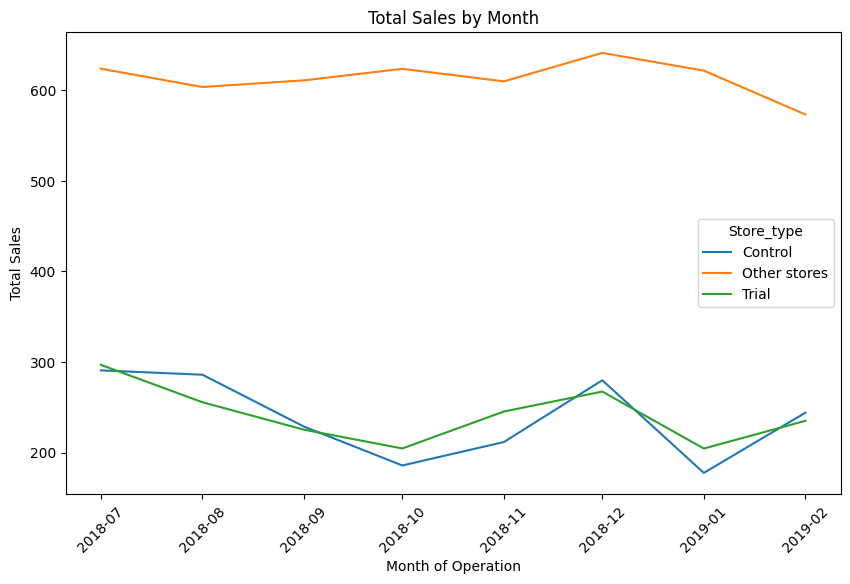

In [27]:
trial_store = 77
control_store = 233 

# Create 'Store_type' column based on store numbers
store_month_metrics['Store_type'] = store_month_metrics['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate average sales by YEARMONTH and Store_type
pastSales = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'totSales': 'mean'})

# Convert YEARMONTH to a datetime format for proper plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plot total sales over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


We can see that the control store 233 and trial store 77 sales are indeed similar in the period before the trial.

Visual graph dueing the trial

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

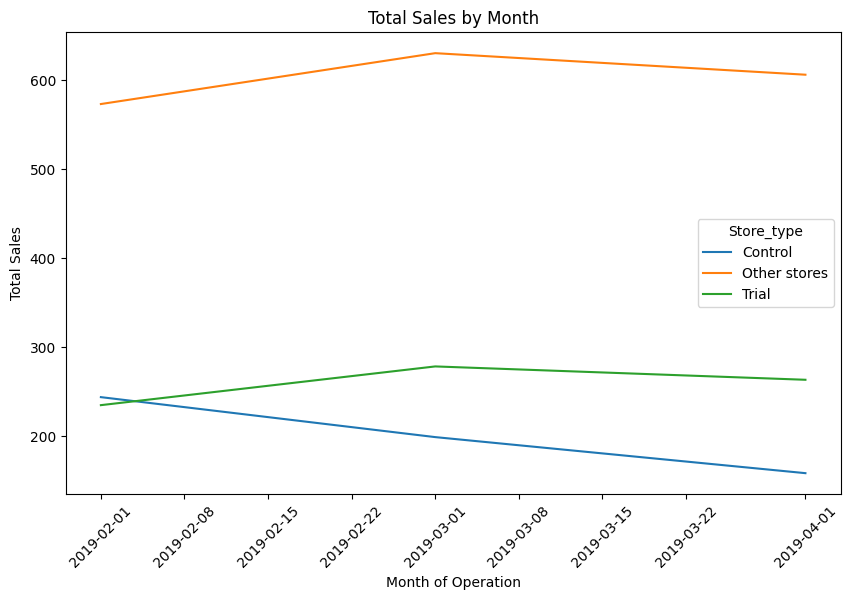

In [34]:
trial_store = 77
control_store = 233 

# Create 'Store_type' column based on store numbers
store_month_metrics['Store_type'] = store_month_metrics['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate average sales by YEARMONTH and Store_type
pastSales = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'totSales': 'mean'})

# Convert YEARMONTH to a datetime format for proper plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastSales = pastSales[pastSales['YEARMONTH'].between(201902,201904)]

# Plot total sales over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


Same with customers

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

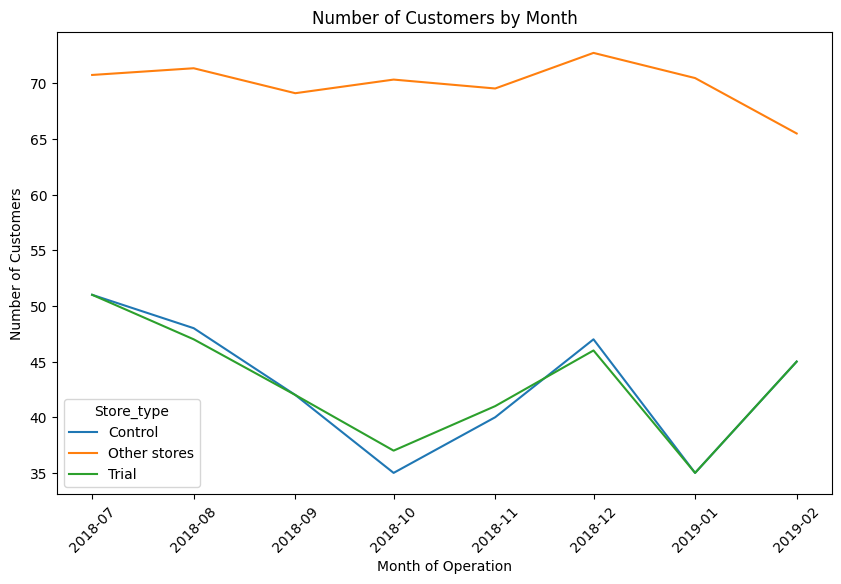

In [23]:
# Calculate average number of customers by YEARMONTH and Store_type
pastCustomers = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'nCustomers': 'mean'})

# Convert YEARMONTH to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plot number of customers over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


We can see that the control store and trial store number of customers are indeed similar in the period before the trial.

similarly for other trial stores, we find out the best control store based on final score values. we are creating a reusable function to calculate the final similarity scores (based on correlation and magnitude) for any given trial store:

In [35]:
def get_final_scores(trial_store, corr_weight=0.5):
    # Calculate correlation
    corr_nsales = calcCorrTable(["totSales"], storeComparison=trial_store)
    corr_ncustomers = calcCorrTable(["nCustomers"], storeComparison=trial_store)

    # Calculate magnitude distance
    magnitude_nsales = calculate_magnitude_distance(pre_trial_metrics, "totSales", trial_store)
    magnitude_ncustomers = calculate_magnitude_distance(pre_trial_metrics, "nCustomers", trial_store)

    # Score for total sales
    score_nSales = pd.merge(corr_nsales, magnitude_nsales, on=['Trial_Str', 'Ctrl_Str'])
    score_nSales['scoreNSales'] = (
        corr_weight * score_nSales['Avg_Corr_Score'] +
        (1 - corr_weight) * score_nSales['mag_measure']
    )
    score_nSales = score_nSales.sort_values(by='scoreNSales', ascending=False)

    # Score for number of customers
    score_nCustomers = pd.merge(corr_ncustomers, magnitude_ncustomers, on=['Trial_Str', 'Ctrl_Str'])
    score_nCustomers['scoreNCust'] = (
        corr_weight * score_nCustomers['Avg_Corr_Score'] +
        (1 - corr_weight) * score_nCustomers['mag_measure']
    )
    score_nCustomers = score_nCustomers.sort_values(by='scoreNCust', ascending=False)

    # Final score
    final_scores = pd.merge(
        score_nSales[['Ctrl_Str', 'scoreNSales']],
        score_nCustomers[['Ctrl_Str', 'scoreNCust']],
        on='Ctrl_Str'
    )

    final_scores['finalScore'] = (
        corr_weight * final_scores['scoreNSales'] +
        (1 - corr_weight) * final_scores['scoreNCust']
    )
    final_scores = final_scores.sort_values(by='finalScore', ascending=False)

    return final_scores


In [25]:
for trial in [86, 88]:
    result = get_final_scores(trial)
    print(result.head(3))
    print(f"Store {result.iloc[0]['Ctrl_Str']} will be a control store for trial store {trial}.")

   Ctrl_Str  scoreNSales  scoreNCust  finalScore
0       155     0.911052    0.827712    0.869382
3       147     0.797875    0.836316    0.817096
6       222     0.785052    0.831219    0.808136
Store 155.0 will be a control store for trial store 86.
   Ctrl_Str  scoreNSales  scoreNCust  finalScore
0       237     0.802393    0.973747    0.888070
5       178     0.699759    0.861442    0.780601
9       123     0.637670    0.827225    0.732448
Store 237.0 will be a control store for trial store 88.


# Visual checks on trends based on the drivers for stores 86,155 and 88,237 with other stores by total sales and total number of customers in the period before the trial

**Trial store 86, Control Store 155**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

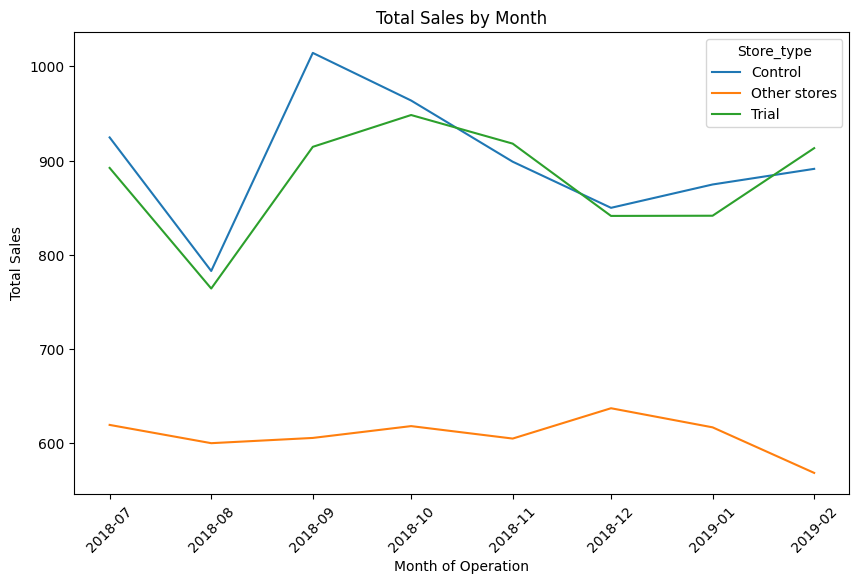

In [37]:
trial_store = 86
control_store = 155 

# Create 'Store_type' column based on store numbers
store_month_metrics['Store_type'] = store_month_metrics['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate average sales by YEARMONTH and Store_type
pastSales = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'totSales': 'mean'})

# Convert YEARMONTH to a datetime format for proper plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plot total sales over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

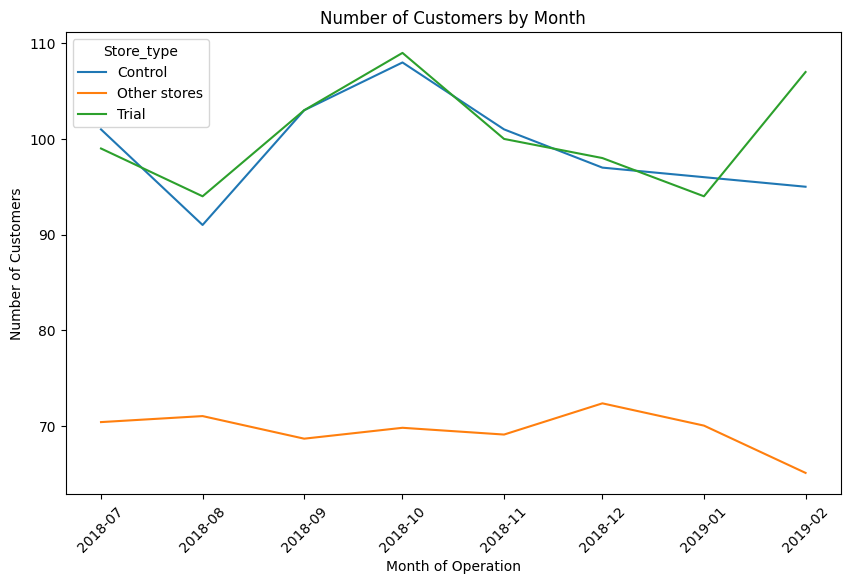

In [38]:
# Calculate average number of customers by YEARMONTH and Store_type
pastCustomers = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'nCustomers': 'mean'})

# Convert YEARMONTH to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plot number of customers over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


**Trial store 88, Control Store 237**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

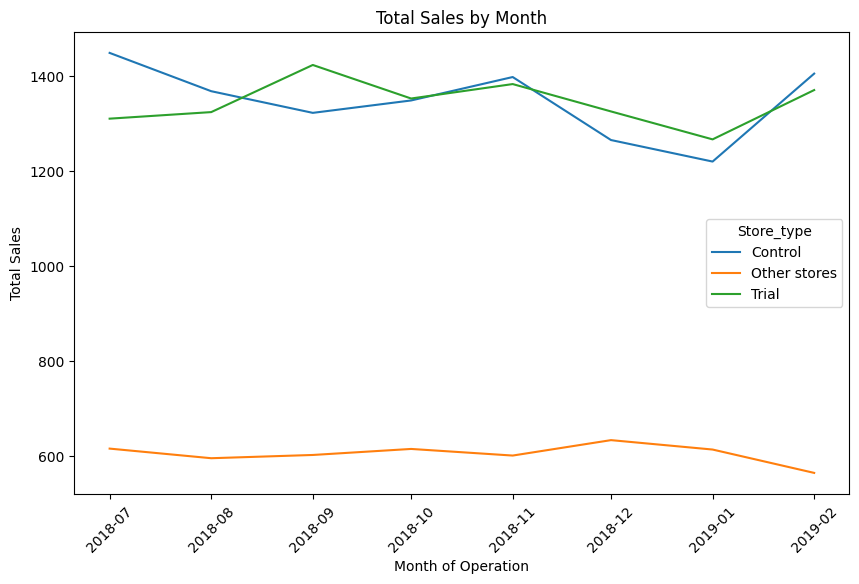

In [39]:
trial_store = 88
control_store = 237

# Create 'Store_type' column based on store numbers
store_month_metrics['Store_type'] = store_month_metrics['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Calculate average sales by YEARMONTH and Store_type
pastSales = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'totSales': 'mean'})

# Convert YEARMONTH to a datetime format for proper plotting
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Plot total sales over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

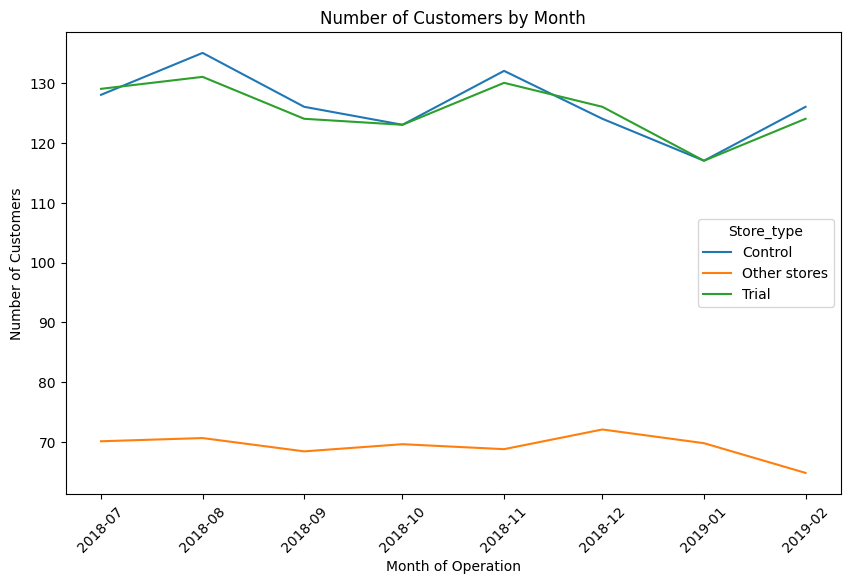

In [40]:
# Calculate average number of customers by YEARMONTH and Store_type
pastCustomers = store_month_metrics.groupby(['YEARMONTH', 'Store_type'], as_index=False).agg({'nCustomers': 'mean'})

# Convert YEARMONTH to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter for data before the trial (for example, before March 2019)
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Plot number of customers over time for each store type
plt.figure(figsize=(10,6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

<ipython-input-41-7fc07baf9fe6>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[297.56555 292.65216 233.99892 190.08572 216.5974  286.4081  181.69206
 249.76262 203.8022  162.3457  352.53378 226.21942]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control', 'controlSales'] = data.loc[data['Store_type'] == 'Control', 'totSales'] * scaling_factor
<ipython-input-41-7fc07baf9fe6>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[896.9222  759.26996 984.03406 934.9487  871.89453 824.3613  848.41895
 864.52203 780.3204  819.31696 895.22455 831.53986]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control', 'controlSales'] = data.loc[data['Store_type'] == 'Control', 'totSales']

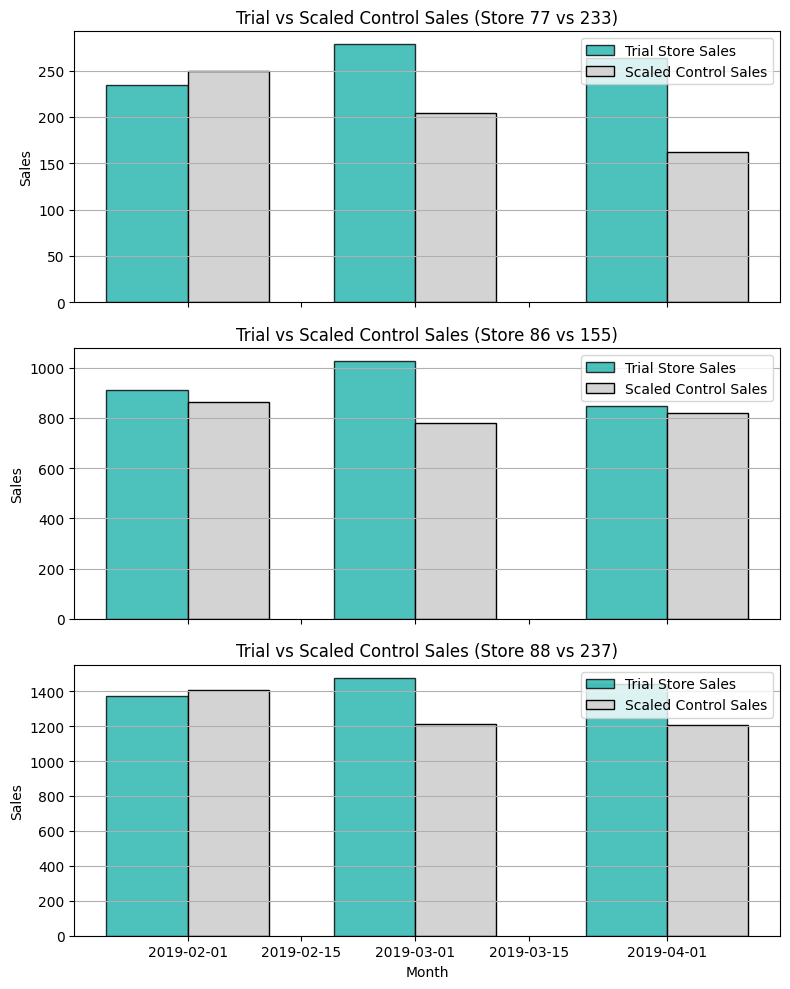

In [41]:
# List of (trial_store, control_store) pairs
store_pairs = [(77, 233), (86, 155), (88, 237)]

# Convert YEARMONTH to datetime once
store_month_metrics['TransactionMonth'] = pd.to_datetime(store_month_metrics['YEARMONTH'].astype(str), format='%Y%m')

# Set up a 3-panel plot for bar charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

for i, (trial_store, control_store) in enumerate(store_pairs):
    # Filter data for the two stores
    data = store_month_metrics[
        store_month_metrics['STORE_NBR'].isin([trial_store, control_store])
    ].copy()

    # Assign store type
    data['Store_type'] = data['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else 'Control'
    )

    # Split into pre-trial and trial periods
    pre_trial_df = data[data['YEARMONTH'] < 201902].copy()

    # Get sales
    pre_trial_trial_sales = pre_trial_df[pre_trial_df['Store_type'] == 'Trial'][['YEARMONTH', 'totSales']].rename(columns={'totSales': 'TrialSales'})
    pre_trial_control_sales = pre_trial_df[pre_trial_df['Store_type'] == 'Control'][['YEARMONTH', 'totSales']].rename(columns={'totSales': 'ControlSales'})

    # Merge on YEARMONTH
    pre_trial_merged = pd.merge(pre_trial_trial_sales, pre_trial_control_sales, on='YEARMONTH')

    # Scaling factor
    scaling_factor = pre_trial_merged['TrialSales'].sum() / pre_trial_merged['ControlSales'].sum()

    # Apply scaled sales
    data['controlSales'] = 0
    data.loc[data['Store_type'] == 'Control', 'controlSales'] = data.loc[data['Store_type'] == 'Control', 'totSales'] * scaling_factor

    # Filter trial period only for plotting
    trial_data = data[data['YEARMONTH'].between(201902, 201904)]
    trial_sales = trial_data[trial_data['Store_type'] == 'Trial'][['TransactionMonth', 'totSales']].rename(columns={'totSales': 'TrialSales'})
    control_sales = trial_data[trial_data['Store_type'] == 'Control'][['TransactionMonth', 'controlSales']].rename(columns={'controlSales': 'ScaledControlSales'})

    merged_trial = pd.merge(trial_sales, control_sales, on='TransactionMonth')

    # Plot bar chart side by side
    bar_width = 10  # days
    axes[i].bar(merged_trial['TransactionMonth'] - pd.Timedelta(days=bar_width / 2), 
                merged_trial['TrialSales'], width=bar_width, label='Trial Store Sales',color='LightSeaGreen',edgecolor='black',alpha=0.8 )
    axes[i].bar(merged_trial['TransactionMonth'] + pd.Timedelta(days=bar_width / 2), 
                merged_trial['ScaledControlSales'], width=bar_width, label='Scaled Control Sales',color='LightGray',edgecolor='black')

    axes[i].set_title(f'Trial vs Scaled Control Sales (Store {trial_store} vs {control_store})')
    axes[i].set_ylabel('Sales')
    axes[i].legend()
    axes[i].grid(True, axis='y')

# Common x-axis label
plt.xlabel('Month')
plt.tight_layout()
plt.show()


<ipython-input-42-b128ae2a2adf>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[51.17114094 48.16107383 42.1409396  35.11744966 40.13422819 47.15771812
 35.11744966 45.15100671 40.13422819 30.10067114 57.19127517 41.13758389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control', 'ScaledControlCustomers'] = data.loc[data['Store_type'] == 'Control', 'nCustomers'] * scaling_factor
<ipython-input-42-b128ae2a2adf>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[127.27683616 134.23728814 125.28813559 122.30508475 131.25423729
 123.29943503 116.33898305 125.28813559 118.32768362 119.3220339
 128.27118644 118.32768362]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control',

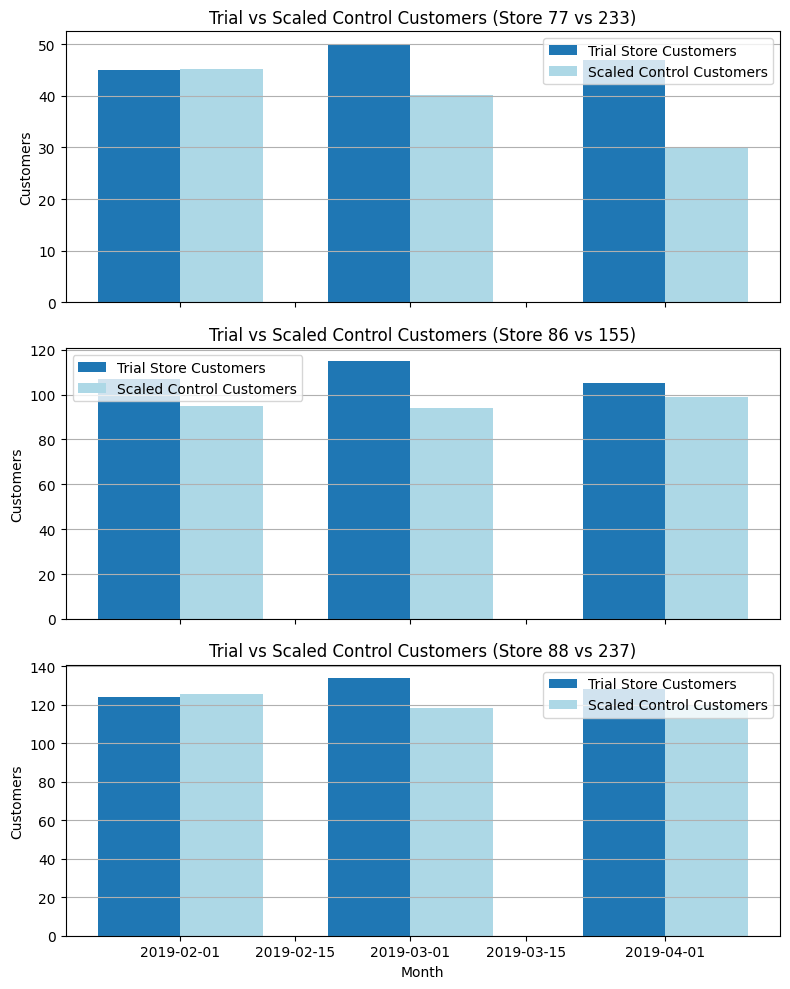

In [42]:
# List of (trial_store, control_store) pairs
store_pairs = [(77, 233), (86, 155), (88, 237)]

# Convert YEARMONTH to datetime once
store_month_metrics['TransactionMonth'] = pd.to_datetime(store_month_metrics['YEARMONTH'].astype(str), format='%Y%m')

# Set up a 3-panel plot for bar charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10), sharex=True)

for i, (trial_store, control_store) in enumerate(store_pairs):
    # Filter data for the two stores
    data = store_month_metrics[
        store_month_metrics['STORE_NBR'].isin([trial_store, control_store])
    ].copy()

    # Assign store type
    data['Store_type'] = data['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else 'Control'
    )

    # Split into pre-trial and trial periods
    pre_trial_df = data[data['YEARMONTH'] < 201902].copy()

    # Get customer counts
    pre_trial_trial_customers = pre_trial_df[pre_trial_df['Store_type'] == 'Trial'][['YEARMONTH', 'nCustomers']].rename(columns={'nCustomers': 'TrialCustomers'})
    pre_trial_control_customers = pre_trial_df[pre_trial_df['Store_type'] == 'Control'][['YEARMONTH', 'nCustomers']].rename(columns={'nCustomers': 'ControlCustomers'})

    # Merge on YEARMONTH
    pre_trial_merged = pd.merge(pre_trial_trial_customers, pre_trial_control_customers, on='YEARMONTH')

    # Scaling factor
    scaling_factor = pre_trial_merged['TrialCustomers'].sum() / pre_trial_merged['ControlCustomers'].sum()

    # Apply scaled customer counts
    data['ScaledControlCustomers'] = 0
    data.loc[data['Store_type'] == 'Control', 'ScaledControlCustomers'] = data.loc[data['Store_type'] == 'Control', 'nCustomers'] * scaling_factor

    # Filter trial period only for plotting
    trial_data = data[data['YEARMONTH'].between(201902, 201904)]
    trial_customers = trial_data[trial_data['Store_type'] == 'Trial'][['TransactionMonth', 'nCustomers']].rename(columns={'nCustomers': 'TrialCustomers'})
    control_customers = trial_data[trial_data['Store_type'] == 'Control'][['TransactionMonth', 'ScaledControlCustomers']]

    merged_trial = pd.merge(trial_customers, control_customers, on='TransactionMonth')

    # Plot bar chart side by side
    bar_width = 10  # days
    axes[i].bar(merged_trial['TransactionMonth'] - pd.Timedelta(days=bar_width / 2), 
                merged_trial['TrialCustomers'], width=bar_width, label='Trial Store Customers')
    axes[i].bar(merged_trial['TransactionMonth'] + pd.Timedelta(days=bar_width / 2), 
                merged_trial['ScaledControlCustomers'], width=bar_width, label='Scaled Control Customers',color="lightblue")

    axes[i].set_title(f'Trial vs Scaled Control Customers (Store {trial_store} vs {control_store})')
    axes[i].set_ylabel('Customers')
    axes[i].legend()
    axes[i].grid(True, axis='y')

# Common x-axis label
plt.xlabel('Month')
plt.tight_layout()
plt.show()


CONCLUSION:
We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.
 

<ipython-input-43-e81437a4c720>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[51.17114094 48.16107383 42.1409396  35.11744966 40.13422819 47.15771812
 35.11744966 45.15100671 40.13422819 30.10067114 57.19127517 41.13758389]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control', 'ScaledControlCustomers'] = data.loc[data['Store_type'] == 'Control', 'nCustomers'] * scaling_factor


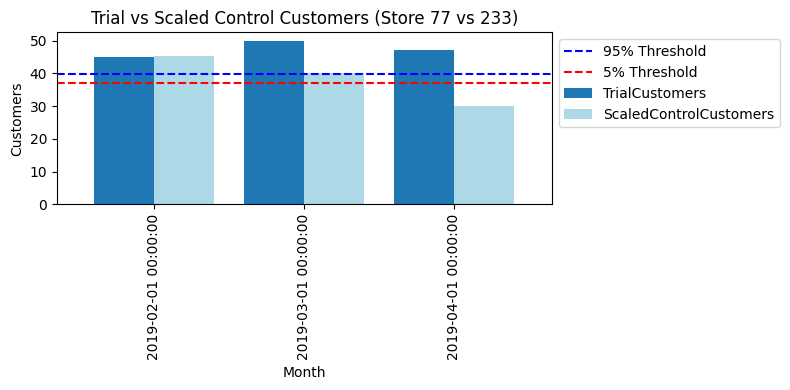

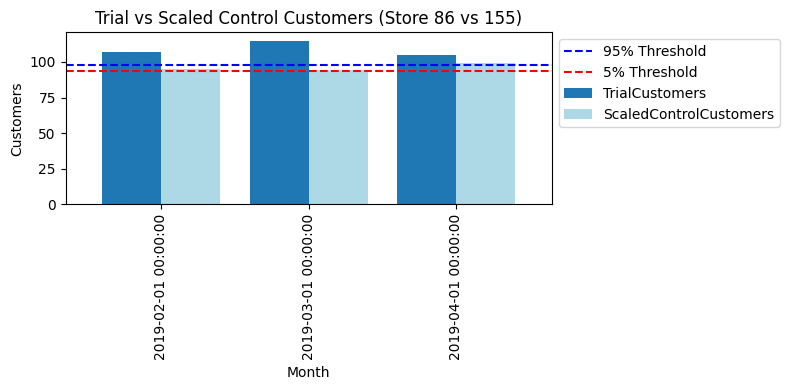

<ipython-input-43-e81437a4c720>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[127.27683616 134.23728814 125.28813559 122.30508475 131.25423729
 123.29943503 116.33898305 125.28813559 118.32768362 119.3220339
 128.27118644 118.32768362]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Store_type'] == 'Control', 'ScaledControlCustomers'] = data.loc[data['Store_type'] == 'Control', 'nCustomers'] * scaling_factor


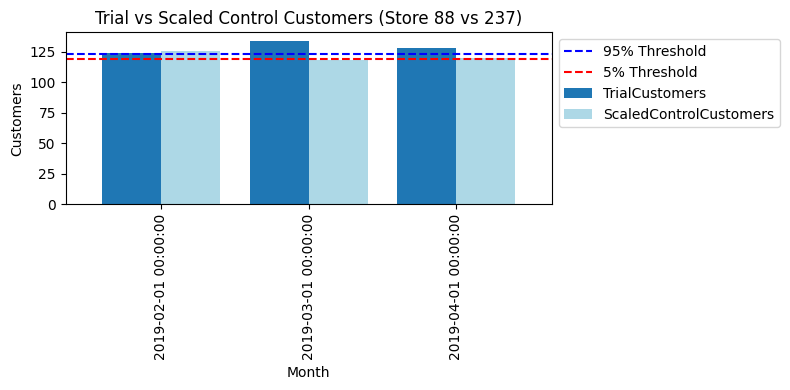

In [43]:
for trial_store, control_store in store_pairs:
    # Filter for the pair
    data = store_month_metrics[
        store_month_metrics['STORE_NBR'].isin([trial_store, control_store])
    ].copy()

    # Assign Trial/Control
    data['Store_type'] = data['STORE_NBR'].apply(lambda x: 'Trial' if x == trial_store else 'Control')

    # Pre-trial period
    pre_trial_df = data[data['YEARMONTH'] < 201902].copy()

    # Trial & Control customers
    pre_trial_trial_customers = pre_trial_df[pre_trial_df['Store_type'] == 'Trial'][['YEARMONTH', 'nCustomers']].rename(columns={'nCustomers': 'TrialCustomers'})
    pre_trial_control_customers = pre_trial_df[pre_trial_df['Store_type'] == 'Control'][['YEARMONTH', 'nCustomers']].rename(columns={'nCustomers': 'ControlCustomers'})

    # Merge and scale
    pre_trial_merged = pd.merge(pre_trial_trial_customers, pre_trial_control_customers, on='YEARMONTH')
    scaling_factor = pre_trial_merged['TrialCustomers'].sum() / pre_trial_merged['ControlCustomers'].sum()

    # Apply scaling
    data['ScaledControlCustomers'] = 0
    data.loc[data['Store_type'] == 'Control', 'ScaledControlCustomers'] = data.loc[data['Store_type'] == 'Control', 'nCustomers'] * scaling_factor

    # Trial period only
    trial_data = data[data['YEARMONTH'].between(201902, 201904)]
    trial_customers = trial_data[trial_data['Store_type'] == 'Trial'][['TransactionMonth', 'nCustomers']].rename(columns={'nCustomers': 'TrialCustomers'})
    control_customers = trial_data[trial_data['Store_type'] == 'Control'][['TransactionMonth', 'ScaledControlCustomers']]

    # Merge trial and control
    merged_trial = pd.merge(trial_customers, control_customers, on='TransactionMonth')

    # Plotting
    bar_width = 10
    ax = merged_trial.plot.bar(
        x='TransactionMonth',
        y=['TrialCustomers', 'ScaledControlCustomers'],
        figsize=(8, 4),
        width=0.8,
        color=['#1f77b4', 'lightblue'],
        title=f'Trial vs Scaled Control Customers (Store {trial_store} vs {control_store})'
    )

    # Thresholds based on pre-trial % difference
    pre_trial_merged['Cust_Pct_Diff'] = abs(pre_trial_merged['TrialCustomers'] - pre_trial_merged['ControlCustomers'] * scaling_factor) / pre_trial_merged['ControlCustomers']
    std_dev = pre_trial_merged['Cust_Pct_Diff'].std()

    mean_control_scaled = merged_trial['ScaledControlCustomers'].mean()
    thresh95 = mean_control_scaled + (mean_control_scaled * std_dev * 2)
    thresh5 = mean_control_scaled - (mean_control_scaled * std_dev * 2)

    # Add threshold lines
    plt.axhline(y=thresh95, color='blue', linestyle='--', label='95% Threshold')
    plt.axhline(y=thresh5, color='red', linestyle='--', label='5% Threshold')

    # Labels, legend, save
    plt.ylabel('Customers')
    plt.xlabel('Month')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'TS_{trial_store}_CS_{control_store}_CUSTOMERS.png', bbox_inches='tight')
    plt.show()


In [ ]:
for trial_store, control_store in store_pairs:
    # Filter for the pair
    data = store_month_metrics[
        store_month_metrics['STORE_NBR'].isin([trial_store, control_store])
    ].copy()

    # Assign Trial/Control
    data['Store_type'] = data['STORE_NBR'].apply(lambda x: 'Trial' if x == trial_store else 'Control')

    # Pre-trial period
    pre_trial_df = data[data['YEARMONTH'] < 201902].copy()

    # Trial & Control sales
    pre_trial_trial_sales = pre_trial_df[pre_trial_df['Store_type'] == 'Trial'][['YEARMONTH', 'totSales']].rename(columns={'totSales': 'TrialSales'})
    pre_trial_control_sales = pre_trial_df[pre_trial_df['Store_type'] == 'Control'][['YEARMONTH', 'totSales']].rename(columns={'totSales': 'ControlSales'})

    # Merge and scale
    pre_trial_merged = pd.merge(pre_trial_trial_sales, pre_trial_control_sales, on='YEARMONTH')
    scaling_factor = pre_trial_merged['TrialSales'].sum() / pre_trial_merged['ControlSales'].sum()

    # Apply scaling
    data['ScaledControlSales'] = 0
    data.loc[data['Store_type'] == 'Control', 'ScaledControlSales'] = data.loc[data['Store_type'] == 'Control', 'totSales'] * scaling_factor

    # Trial period only
    trial_data = data[data['YEARMONTH'].between(201902, 201904)]
    trial_sales = trial_data[trial_data['Store_type'] == 'Trial'][['TransactionMonth', 'totSales']].rename(columns={'totSales': 'TrialSales'})
    control_sales = trial_data[trial_data['Store_type'] == 'Control'][['TransactionMonth', 'ScaledControlSales']]

    # Merge trial and control
    merged_trial = pd.merge(trial_sales, control_sales, on='TransactionMonth')

    # Plotting
    bar_width = 10
    ax = merged_trial.plot.bar(
        x='TransactionMonth',
        y=['TrialSales', 'ScaledControlSales'],
        figsize=(8, 4),
        width=0.8,
        color=['#1f77b4', 'lightblue'],
        title=f'Trial vs Scaled Control Sales (Store {trial_store} vs {control_store})'
    )

    # Thresholds based on pre-trial % difference
    pre_trial_merged['Sales_Pct_Diff'] = abs(pre_trial_merged['TrialSales'] - pre_trial_merged['ControlSales'] * scaling_factor) / pre_trial_merged['ControlSales']
    std_dev = pre_trial_merged['Sales_Pct_Diff'].std()

    mean_control_scaled = merged_trial['ScaledControlSales'].mean()
    thresh95 = mean_control_scaled + (mean_control_scaled * std_dev * 2)
    thresh5 = mean_control_scaled - (mean_control_scaled * std_dev * 2)

    # Add threshold lines
    plt.axhline(y=thresh95, color='blue', linestyle='--', label='95% Threshold')
    plt.axhline(y=thresh5, color='red', linestyle='--', label='5% Threshold')

    # Labels, legend, save
    plt.ylabel('Total Sales')
    plt.xlabel('Month')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'TS_{trial_store}_CS_{control_store}_SALES.png', bbox_inches='tight')
    plt.show()
